In [11]:
#Gdrive mounting

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pip install pydub
!pip install ffmpeg
!pip install librosa
!pip install essentia

In [13]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import essentia.standard as es


## AIF to WAV recursive directory

In [5]:
import os
from pydub import AudioSegment

def convert_aif_to_wav(source_folder, destination_folder):
    # Traverse all subfolders and files
    for root, dirs, files in os.walk(source_folder):
        # Calculate the relative path to replicate the structure
        relative_path = os.path.relpath(root, source_folder)
        destination_subfolder = os.path.join(destination_folder, relative_path)

        # Create the subfolder in the destination if it doesn't exist
        if not os.path.exists(destination_subfolder):
            os.makedirs(destination_subfolder)

        for file in files:
            if file.lower().endswith(('.aif', '.aiff')):  # AIF or AIFF files
                aif_path = os.path.join(root, file)  # Full path of the AIF file
                wav_filename = os.path.splitext(file)[0] + ".wav"  # WAV file name
                wav_path = os.path.join(destination_subfolder, wav_filename)  # Full output path for .wav

                # Convert AIF to WAV
                audio = AudioSegment.from_file(aif_path, format="aiff")
                audio.export(wav_path, format="wav")

                print(f"Converted: {aif_path} -> {wav_path}")




## Plot all audio files from folder, SaveAudioToWav


In [4]:
import os
import librosa
import matplotlib.pyplot as plt


import essentia.standard as es


#SAVE AUDIO IN PATH
def save_audio_to_wav(audio_data, sampling_rate, file_path):
    """
    Save the provided audio data to a WAV file using Essentia.

    :param period_data: numpy array, the audio data to save.
    :param sampling_rate: int, the sampling rate of the audio data.
    :param new_file_path: str, the file path where the WAV file will be saved.
    """
    # Create the MonoWriter object with the desired output file path and sample rate
    writer = es.MonoWriter(filename=file_path, format='wav', sampleRate=sampling_rate)

    # Write the audio data to the file
    writer(audio_data)

    print(f"Audio saved to {file_path}")




# Function to sort files alphabetically
def sorted_files(audio_dir):
    """
    Return a list of .wav files sorted alphabetically.

    :param audio_dir: str, path to the directory containing audio files.
    :return: list of sorted .wav file names.
    """
    file_names = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
    return sorted(file_names)  # Sort the file names alphabetically

# AUDIO PLOTTING: plotting all audio from a specific folder: full audio, 4 sec, 0.05 sec, or one period
def plot_audio_files_folder(audio_dir, plot_option=0, start_time=0):
    """
    Plot audio files in a directory. The plot_option parameter controls the duration of the plot:
    - 0: Plot the entire audio.
    - 1: Plot the first 4 seconds of the audio.
    - 2: Plot the first 0.05 seconds of the audio.
    - 3: Plot one period of the audio signal using the get_period function.

    The plots will be organized in a grid with 4 plots per row.

    :param audio_dir: str, path to the directory containing audio files.
    :param plot_option: int, controls the duration of the plot (0, 1, 2, or 3).
    :param start_time: float, start time in seconds to plot the signal from. Defaults to 0 (start from beginning).
    """
    # Get the sorted list of .wav files
    file_names = sorted_files(audio_dir)
    num_files = len(file_names)

    # Calculate the number of rows needed (4 plots per row)
    num_rows = (num_files + 3) // 4

    # Create the subplots with a reduced figure size
    fig, axes = plt.subplots(num_rows, 4, figsize=(8, num_rows * 2.4))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    # Add supratitle with the name of the last part of the directory path
    folder_name = os.path.basename(os.path.normpath(audio_dir))
    plt.suptitle(f'Audio Files from: {folder_name}', fontsize=16)

    for i, file_name in enumerate(file_names):
        file_path = os.path.join(audio_dir, file_name)

        # Load the audio file
        audio_data, sampling_rate = librosa.load(file_path, sr=None)

        # Determine the start sample based on start_time
        start_sample = int(start_time * sampling_rate)

        # Determine the duration to plot based on plot_option
        if plot_option == 1:
            num_samples = int(4 * sampling_rate)  # 4 seconds
        elif plot_option == 2:
            num_samples = int(0.05 * sampling_rate)  # 0.05 seconds

        else:
            num_samples = len(audio_data) - start_sample  # Full audio from start_time

        # Ensure that the number of samples doesn't exceed the available data length
        end_sample = min(start_sample + num_samples, len(audio_data))

        # Plot the waveform
        axes[i].plot(np.linspace(start_time, end_sample / sampling_rate, end_sample - start_sample), audio_data[start_sample:end_sample])
        axes[i].set_title(f'{file_name}')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude')

    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the supratitle
    plt.show()



#PLOT RECURSIVE:
def process_all_subdirectories(main_directory, option=3, start_time=0.0):
    # Loop through all subdirectories in the main directory
    for subdir_name in sorted(os.listdir(main_directory)):
        subdir_path = os.path.join(main_directory, subdir_name)
        if os.path.isdir(subdir_path):
            print(f"Processing folder: {subdir_path}")
            plot_audio_files_folder(subdir_path, option, start_time)



## PROCESSING AUDIO:

- Get 1 period
- Save 1 period audio


In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def get_period_norm(file_path, start_offset=0.01, option=1):
    """
    Detect the first period with a positive zero crossing, ignoring initial transients.

    :param file_path: str, path to the audio file.
    :param start_offset: float, time in seconds to skip from the beginning to avoid transients.
    :param option: int, 0 = do not plot, 1 = plot the signal.
    :return: tuple, the normalized first period segment, the sampling rate, and the detected fundamental frequency (f0).
    """

    # Load the audio file
    audio_data, sampling_rate = librosa.load(file_path, sr=None)

    # Calculate the number of samples corresponding to the offset
    start_sample = int(start_offset * sampling_rate)
    audio_data = audio_data[start_sample:]

    # Find all positive zero crossings in the signal
    zero_crossings = np.where(np.diff(np.sign(audio_data)) > 0)[0]

    if len(zero_crossings) < 2:
        raise ValueError("Not enough positive zero crossings found in the signal.")

    # Start from the first positive zero crossing
    start_idx = zero_crossings[0]

    # Detect the fundamental period using a pitch detection algorithm
    f0, voiced_flag, voiced_probs = librosa.pyin(audio_data, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sampling_rate)

    # Filter out invalid f0 values (NaN)
    f0 = f0[~np.isnan(f0)]

    # Get the most representative fundamental frequency
    if len(f0) > 0:
        fundamental_freq = np.median(f0)
    else:
        raise ValueError("Fundamental frequency could not be detected.")

    # Calculate the period in terms of samples
    period_samples = int(sampling_rate / fundamental_freq)

    # Search for the end of the complete cycle ensuring we cover at least one full period
    end_idx = None
    for j in zero_crossings:
        if j > start_idx + period_samples - int(0.1 * period_samples):  # 10% tolerance to detect the cycle
            end_idx = j
            break

    if end_idx is None:
        raise ValueError("A complete period could not be found based on zero crossings.")

    period_segment = audio_data[start_idx:end_idx]

    # Normalize the period segment
    period_segment_norm = period_segment / np.max(np.abs(period_segment))

    # Plot the first complete period if option == 1
    if option == 1:
        file_name = os.path.basename(file_path)
        plt.figure(figsize=(8, 4))  # More compact figure
        plt.plot(np.linspace(0, len(period_segment) / sampling_rate, len(period_segment)), period_segment_norm)
        plt.title(f'Normalized period from audio {file_name}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()

    return period_segment_norm, sampling_rate, f0

In [ ]:
import os

#get 1 period + save_audio
def save_1period_file(src_file_path, dst_folder):
    """
    Process a single audio file, extract the first period using get_period_norm, and save it to a destination folder.

    :param src_file_path: str, path to the source audio file.
    :param dst_folder: str, path to the destination folder where the processed file will be saved.
    :param plot_option: int, 0 = do not plot, 1 = plot the signal.
    """
    try:
        # Apply get_period_norm to get the period, sampling rate, and f0
        result = get_period_norm(src_file_path, start_offset=0.05, option=1)

        # Check if result is valid (i.e., not None)
        if result is not None:
            period_segment, sampling_rate, f0 = result

            # Generate the new file name with '_1pn' suffix
            file_name = os.path.basename(src_file_path)
            new_file_name = os.path.splitext(file_name)[0] + '_1pn.wav'
            dst_file_path = os.path.join(dst_folder, new_file_name)

            # Save the period segment as a new audio file
            save_audio_to_wav(period_segment, sampling_rate, dst_file_path)

            print(f"Processed and saved: {new_file_name}")
        else:
            print(f"Skipping file {src_file_path} due to an error in get_period_norm.")

    except Exception as e:
        print(f"Error processing {src_file_path}: {str(e)}")






In [83]:

#RENAME AUDIO FILES

import os

def rename_audio_files_recursive(folder_path):
    """
    Recursively rename audio files in the specified folder and its subfolders
    by removing the hyphen before the extension. Changes files named 'A3-6_1-n.wav'
    to 'A3-6_1n.wav'.

    :param folder_path: str, path to the folder containing the audio files.
    """
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.wav'):
                # Create the new file name by removing the hyphen before the extension
                new_file_name = file_name.replace('-n.wav', 'n.wav')

                # Get the full file paths
                old_file_path = os.path.join(root, file_name)
                new_file_path = os.path.join(root, new_file_name)

                # Rename the file
                os.rename(old_file_path, new_file_path)
                print(f'Renamed: {old_file_path} -> {new_file_path}')




## Comparing two signals

In [82]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def compare_2_signals(file1, file2):
    # Load the audio files
    y1, sr1 = librosa.load(file1, sr=None)
    y2, sr2 = librosa.load(file2, sr=None)

    # Check that both signals have the same sampling rate
    if sr1 != sr2:
        raise ValueError("The audio files have different sampling rates.")

    # Create the figure
    plt.figure(figsize=(6, 3))

    # Plot the first signal in blue
    librosa.display.waveshow(y1, sr=sr1, color='blue', label='Audio1')

    # Plot the second signal in orange
    librosa.display.waveshow(y2, sr=sr2, color='orange', alpha=0.5, label='Audio2')

    # Add title and labels
    plt.title('Comparison of two audio files')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Show the plot
    plt.show()




In [85]:

import os
import re
import librosa
import numpy as np
import matplotlib.pyplot as plt

def natural_sort_key(s):
    """Function to sort files considering numbers in the name."""
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]


def compare_and_plot_folders(folder1, folder2, output_image_file="comparison_plot.png"):
    """
    Plot and compare normalized audio files from two folders side by side.
    Organize plots in a 3x4 grid and save the figure.
    Add a general figure supratitle with the note name and individual supratitles with the audio file names.

    :param folder1: str, path to the first folder containing audio files.
    :param folder2: str, path to the second folder containing audio files.
    :param output_image_file: str, path and name of the file where the image will be saved.
    """
    # Get the list of .wav files in each folder and sort them alphabetically using natural sorting
    files1 = sorted([f for f in os.listdir(folder1) if f.endswith('.wav')], key=natural_sort_key)
    files2 = sorted([f for f in os.listdir(folder2) if f.endswith('.wav')], key=natural_sort_key)

    # Extract the note name from the first file (first two characters of the filename)
    note_name = files1[0][:2]

    # Number of files to display per figure (4 columns x 3 rows)
    num_files_per_figure = 12

    # Create subplots for the audio files (3 rows x 4 columns)
    fig, axes = plt.subplots(3, 4, figsize=(20, 10))  # Adjusted figure size for better visualization
    axes = axes.flatten()

    # Add a general supratitle for the entire figure (the name of the note)
    fig.suptitle(f'Comparison of {note_name} Audio Files', fontsize=16)

    # Iterate over the first 12 files or the available ones
    for i in range(min(num_files_per_figure, len(files1), len(files2))):
        file_path1 = os.path.join(folder1, files1[i])
        file_path2 = os.path.join(folder2, files2[i])

        # Extract the audio file name (without extension) for the supratitle and legend
        filename1 = os.path.splitext(os.path.basename(file_path1))[0]
        filename2 = os.path.splitext(os.path.basename(file_path2))[0]

        # Remove the "_1pn" part if it exists
        filename1_clean = filename1.split('_')[0]
        filename2_clean = filename2.split('_')[0]

        # Remove the last character of the filename (e.g., 'k' in 'A2-1bk')
        #filename1_clean = filename1_clean[:-2]
        #filename2_clean = filename2_clean[:-2]

        # Load the audio files
        audio_data1, sr1 = librosa.load(file_path1)
        audio_data2, sr2 = librosa.load(file_path2)

        # Create the time axis for both files
        time1 = np.linspace(0, len(audio_data1) / sr1, len(audio_data1))
        time2 = np.linspace(0, len(audio_data2) / sr2, len(audio_data2))

        # Plot the waveforms from both folders in the same subplot
        axes[i].plot(time1, audio_data1, label=filename1_clean, color='blue')
        axes[i].plot(time2, audio_data2, label=filename2_clean, color='orange')
        axes[i].set_title(f'{filename1_clean}')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Amplitude')
        axes[i].legend()

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout to prevent subplots from overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for the supratitle

    # Save the figure to a file
    plt.savefig(output_image_file, dpi=300, bbox_inches='tight')

    # Show the figure
    plt.show()

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def find_zero_crossing_before_max(signal):
    # Encontrar el índice del valor máximo global
    max_index = np.argmax(signal)

    # Buscar el cruce por cero antes del máximo
    for i in range(max_index, 0, -1):
        if signal[i-1] <= 0 and signal[i] > 0:  # Detecta el cruce por cero positivo
            return i
    return 0  # Si no encuentra un cruce por cero

def align_signals(signal1, signal2):
    # Encontrar el primer cruce por cero antes del máximo en la señal 2
    zero_crossing_index = find_zero_crossing_before_max(signal2)

    # Desplazar la señal 2 para que comience en el cruce por cero
    aligned_signal2 = np.roll(signal2, -zero_crossing_index)

    return aligned_signal2

def align_audio_signals(audio_file_1, audio_file_2):
    """
    Carga dos archivos de audio, alinea la segunda señal con respecto a la primera,
    grafica las señales y devuelve el sampling rate original y la señal alineada.

    Parámetros:
    - audio_file_1: ruta al archivo de la señal 1 (señal original).
    - audio_file_2: ruta al archivo de la señal 2 (señal que se va a alinear).

    Retorno:
    - sampling_rate: frecuencia de muestreo (sampling rate) original de las señales.
    - aligned_signal: señal 2 alineada con respecto a la señal 1.
    """
    # Cargar las señales de audio
    signal1, sr1 = librosa.load(audio_file_1, sr=None)
    signal2, sr2 = librosa.load(audio_file_2, sr=None)

    # Verificamos que las dos señales tengan la misma tasa de muestreo
    if sr1 != sr2:
        raise ValueError("Las señales de audio tienen diferentes tasas de muestreo.")

    # Alinear las señales
    aligned_signal2 = align_signals(signal1, signal2)

    # Graficar las señales
    t1 = np.linspace(0, len(signal1) / sr1, len(signal1))
    t2 = np.linspace(0, len(signal2) / sr2, len(signal2))
    t_aligned = np.linspace(0, len(aligned_signal2) / sr2, len(aligned_signal2))

    plt.figure(figsize=(4, 2.5))
    plt.plot(t1, signal1, label="Señal 1 (original)")
    plt.plot(t2, signal2, label="Señal 2 (antes de alinear)")
    plt.plot(t_aligned, aligned_signal2, label="Señal 2 (alineada)", linestyle='--')
    plt.legend()
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.title("Alineamiento de señales de audio")
    plt.grid(True)
    plt.show()

    return sr1, aligned_signal2


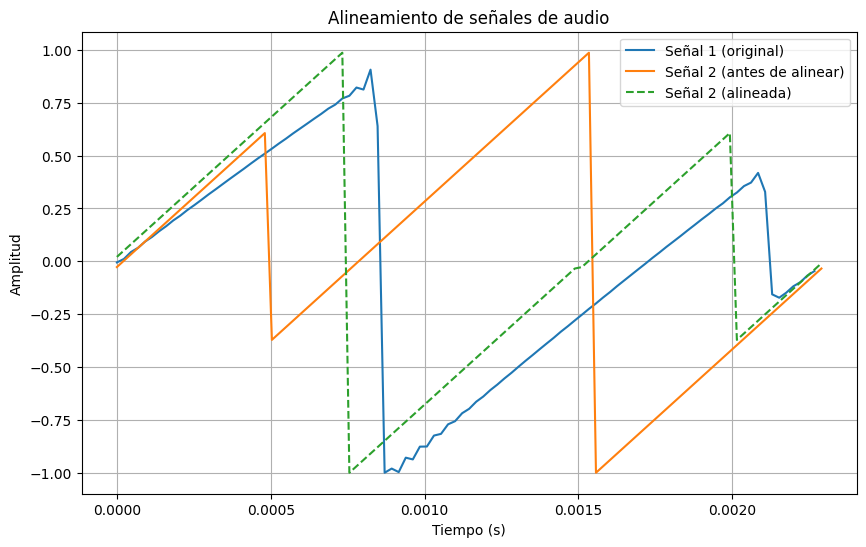

Audio saved to /content/drive/MyDrive/_Thesis/AUDIOS_1period/A4-3bv_1pn-align


In [ ]:
# Ruta de los archivos de audio
audio_file_1 = '/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A4k_1pn/A4-3bk_1pn.wav'
audio_file_2 = '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A4v_1pn/A4-3bv_1pn.wav'
sr, x= align_audio_signals(audio_file_1, audio_file_2)
save_audio_to_wav(x, sr, '/content/drive/MyDrive/_Thesis/AUDIOS_1period/A4-3bv_1pn-align')

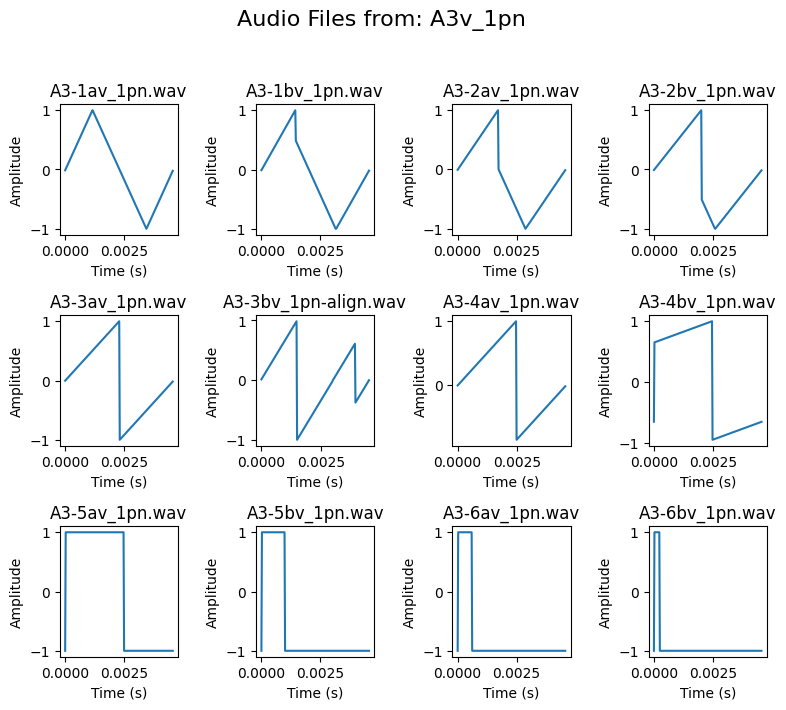

In [ ]:
plot_audio_files_folder('/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A3v_1pn')

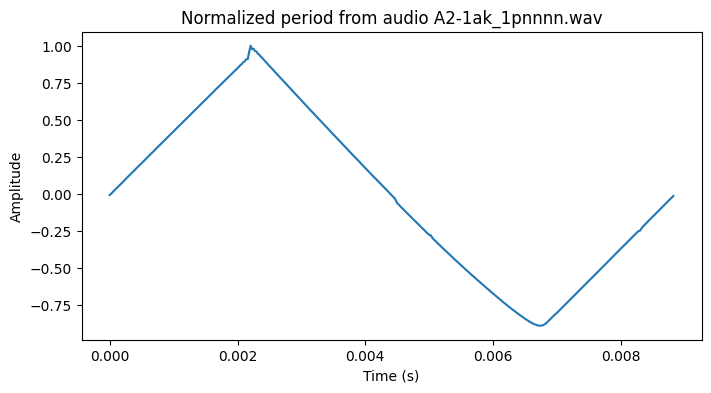

Audio saved to /content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A2k_1pn/A2-1ak_1pn.wav


In [100]:
x, sr, _ = get_period_norm('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A2k_1pn/A2-1ak_1pnnnn.wav', start_offset=0.5, option=1)
save_audio_to_wav(x, sr, '/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A2k_1pn/A2-1ak_1pn.wav')

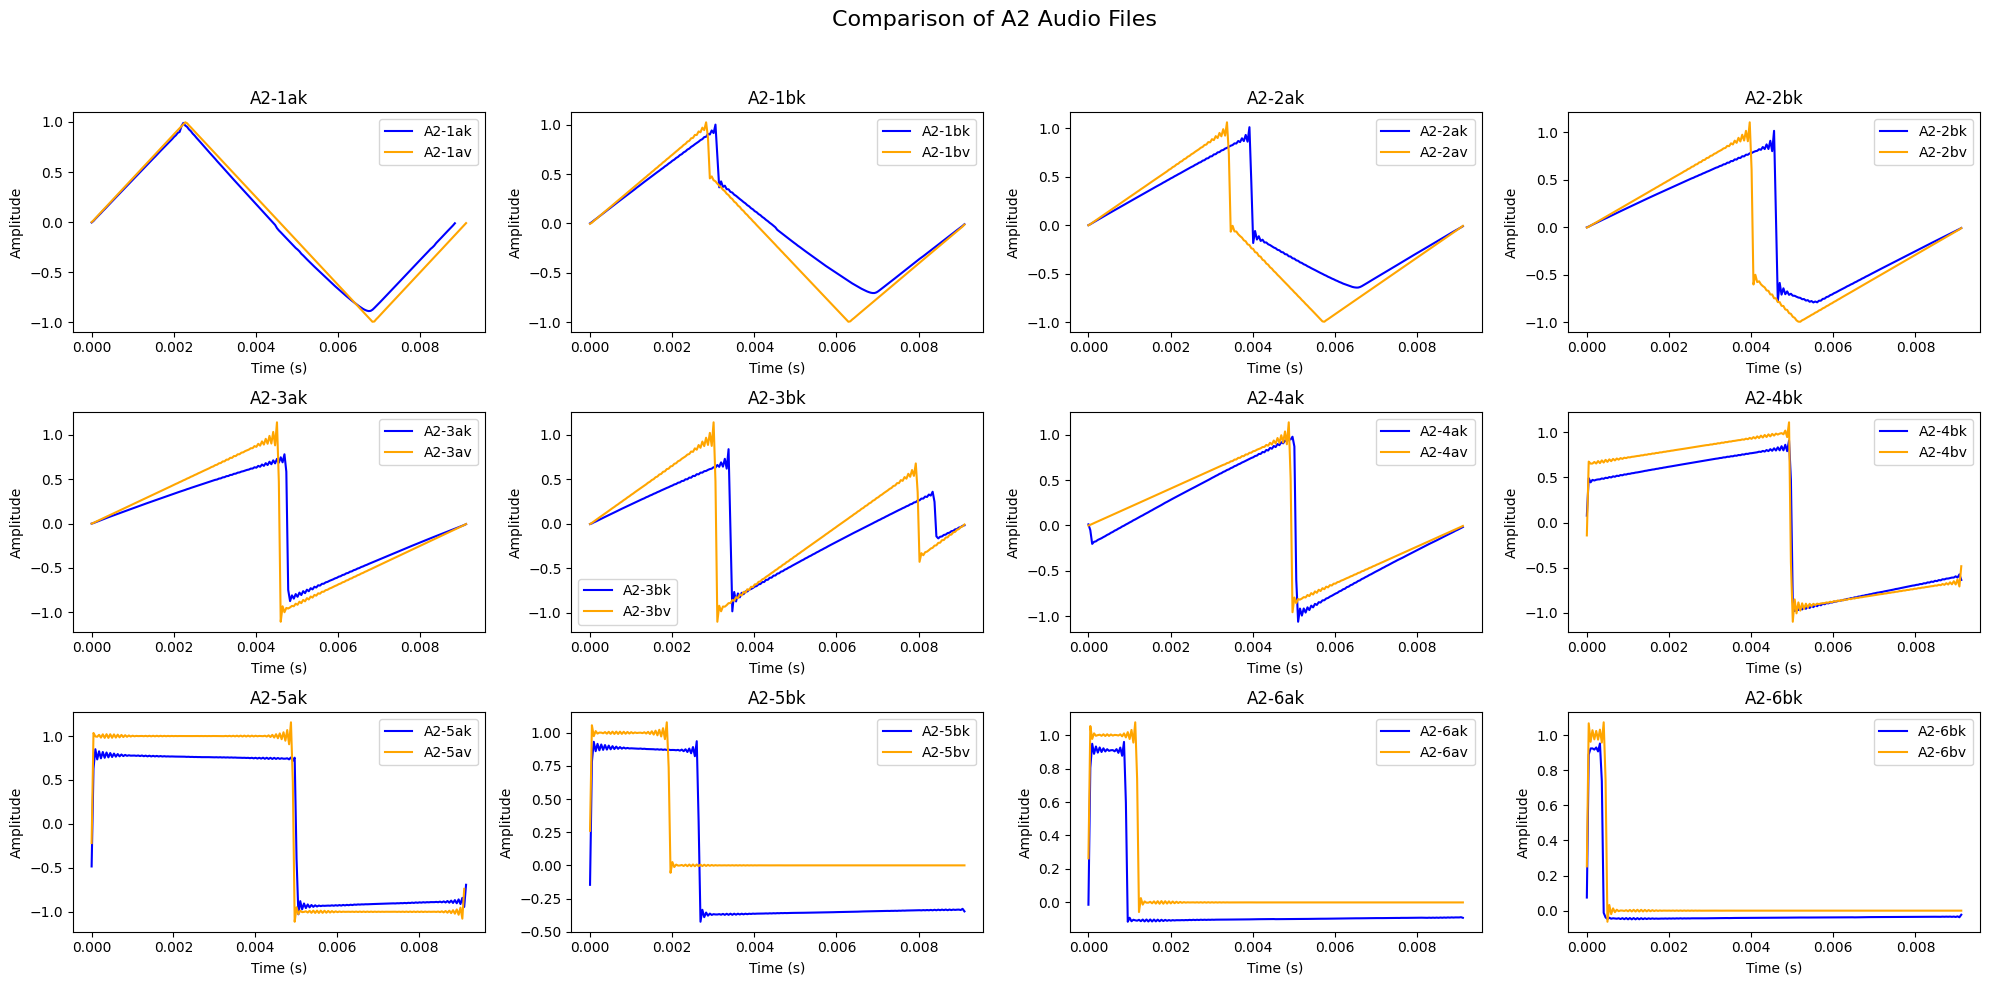

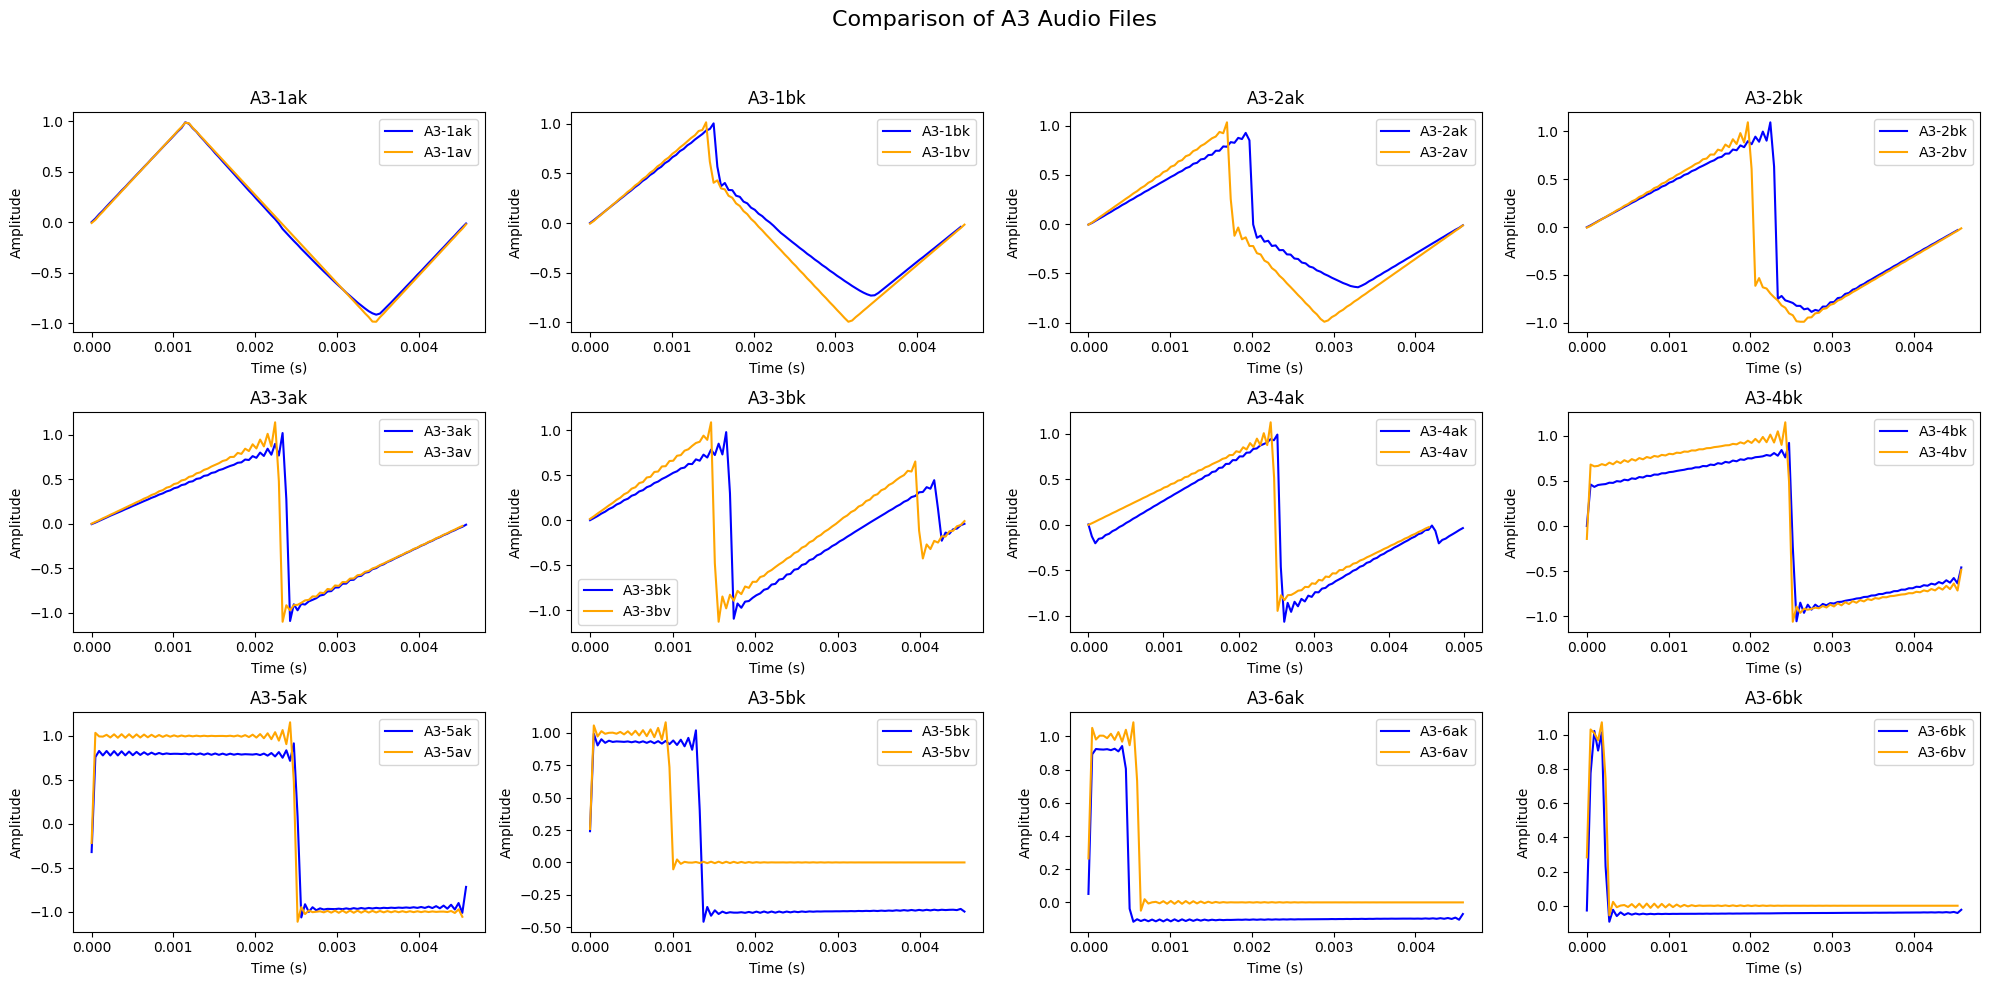

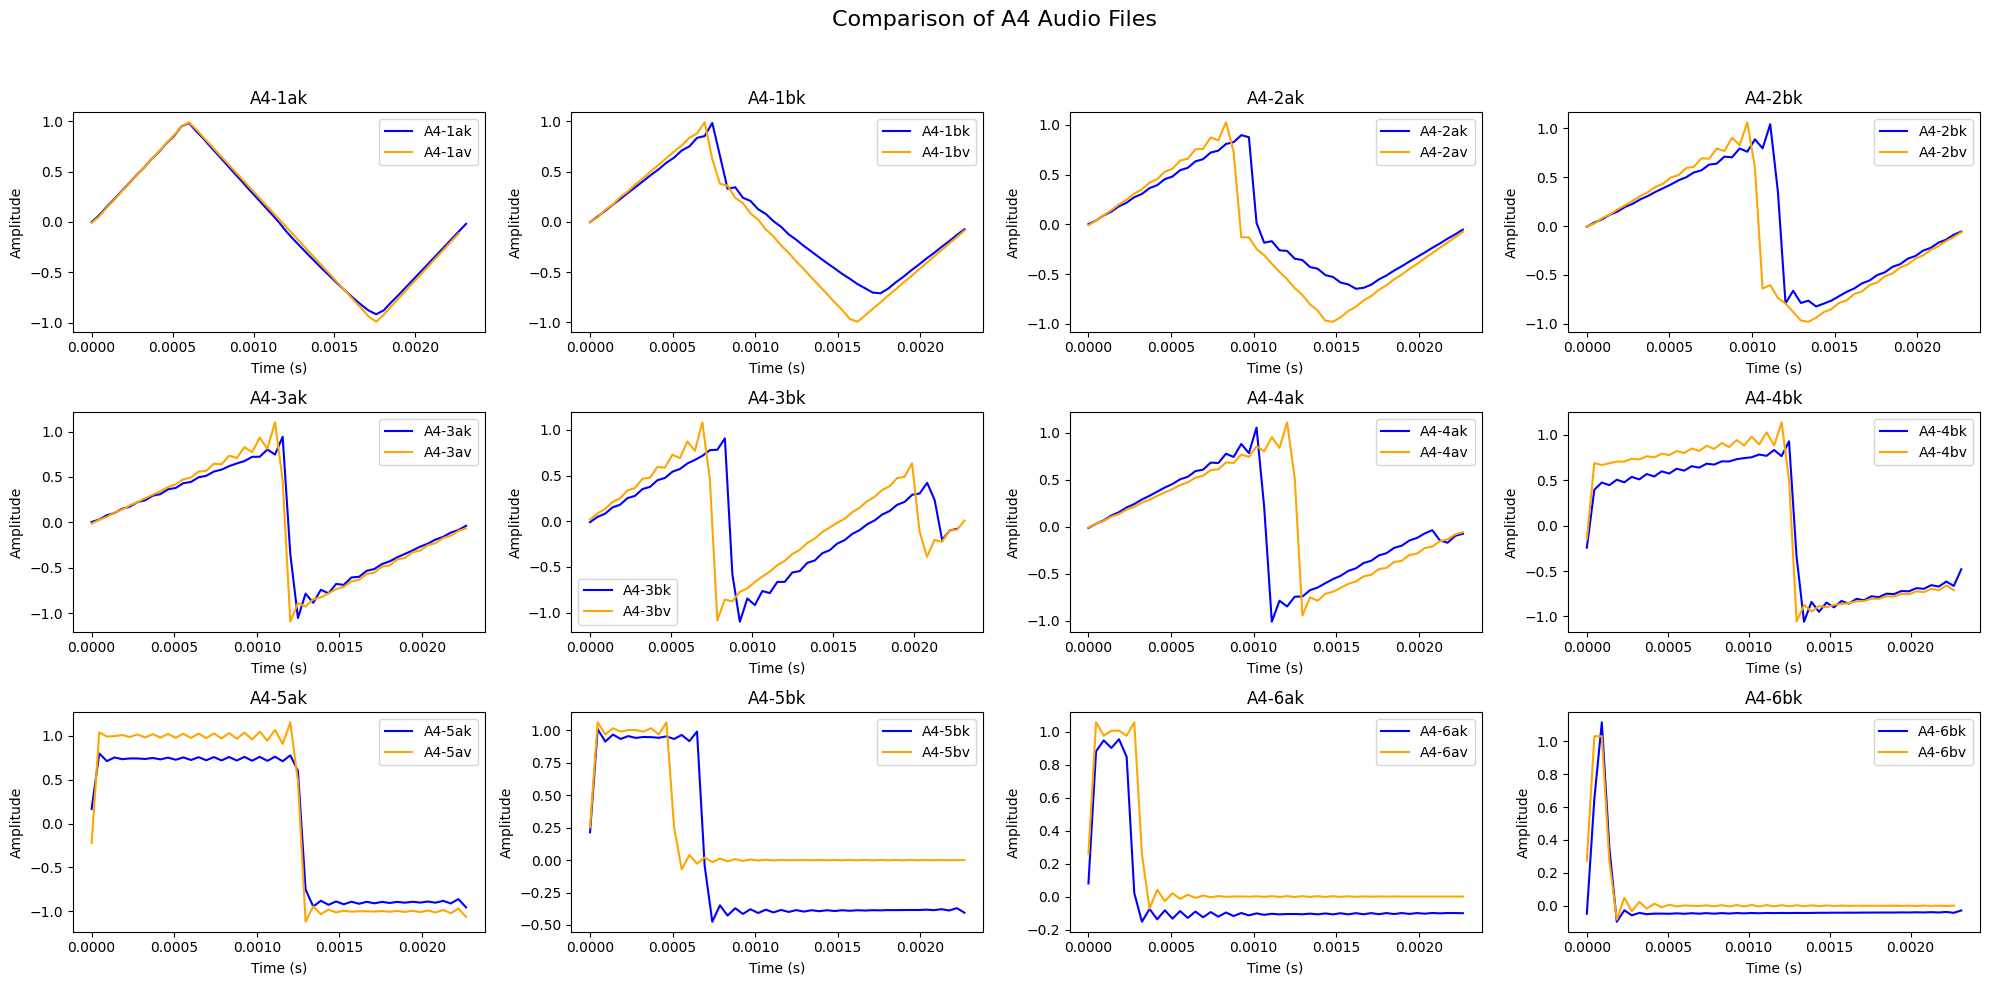

In [101]:
compare_and_plot_folders('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A2k_1pn', '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A2v_1pn')
compare_and_plot_folders('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A3k_1pn', '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A3v_1pn')
compare_and_plot_folders('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A4k_1pn', '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A4v_1pn')


## MSERROR

In [7]:
import os
import librosa


def natural_sort_key(s):
    """Helper function for natural sorting of file names."""
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def calculate_mse(file_path1, file_path2):
    """Placeholder function for calculating MSE between two audio files."""
    audio_data1, sr1 = librosa.load(file_path1, sr=None)
    audio_data2, sr2 = librosa.load(file_path2, sr=None)

    # Ensure both signals have the same sample rate
    if sr1 != sr2:
        raise ValueError("The two signals must have the same sample rate.")

    # Truncate both signals to the length of the shorter one
    min_length = min(len(audio_data1), len(audio_data2))
    signal1 = audio_data1[:min_length]
    signal2 = audio_data2[:min_length]

    # Calculate the MSE
    mse = np.mean((signal1 - signal2) ** 2)

    return mse

def mse_folders(folder1, folder2):
    """
    Compare normalized audio files from two folders side by side.
    Calculate and return the MSE between corresponding files.
    If the number of files in each folder is different, raise an error.

    :param folder1: str, path to the first folder containing audio files.
    :param folder2: str, path to the second folder containing audio files.
    :return: list of MSE values for each pair of files
    """
    # Get the list of .wav files in each folder and sort them alphabetically using natural sorting
    files1 = sorted([f for f in os.listdir(folder1) if f.endswith('.wav')], key=natural_sort_key)
    files2 = sorted([f for f in os.listdir(folder2) if f.endswith('.wav')], key=natural_sort_key)

    # Check if the number of files in each folder is the same
    if len(files1) != len(files2):
        raise ValueError("The number of files in each folder is different.")

    # Calculate the number of files to process
    num_files_to_process = len(files1)

    # Lista para almacenar los valores de MSE
    mse_values = []

    # Iterate over the available files
    for i in range(num_files_to_process):
        file_path1 = os.path.join(folder1, files1[i])
        file_path2 = os.path.join(folder2, files2[i])

        filename = file_path1.split('/')[-1].split('-')[0]

        # Calculate MSE between the corresponding files
        mse_value = calculate_mse(file_path1, file_path2)
        #print(f"MSE for {filename}: {mse_value}")

        # Añadir el valor de MSE a la lista
        mse_values.append(mse_value)
        #print(f"MSE for {filename}: {mse_value}")

    # Devolver el array con los valores de MSE
    return mse_values


In [8]:
import pandas as pd

# Collect results from mse_folders calls
result_A2 = mse_folders('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A2k_1pn', '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A2v_1pn')
result_A3 = mse_folders('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A3k_1pn', '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A3v_1pn')
result_A4 = mse_folders('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A4k_1pn', '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A4v_1pn')

# Round results to 4 decimal places
result_A2 = [round(val, 4) for val in result_A2]
result_A3 = [round(val, 4) for val in result_A3]
result_A4 = [round(val, 4) for val in result_A4]

# Create a DataFrame with the results
data = {
    "1a": [result_A2[0], result_A3[0], result_A4[0]],
    "1b": [result_A2[1], result_A3[1], result_A4[1]],
    "2a": [result_A2[2], result_A3[2], result_A4[2]],
    "2b": [result_A2[3], result_A3[3], result_A4[3]],
    "3a": [result_A2[4], result_A3[4], result_A4[4]],
    "3b": [result_A2[5], result_A3[5], result_A4[5]],
    "4a": [result_A2[6], result_A3[6], result_A4[6]],
    "4b": [result_A2[7], result_A3[7], result_A4[7]],
    "5a": [result_A2[8], result_A3[8], result_A4[8]],
    "5b": [result_A2[9], result_A3[9], result_A4[9]],
    "6a": [result_A2[10], result_A3[10], result_A4[10]],
    "6b": [result_A2[11], result_A3[11], result_A4[11]],
}

# Label rows as A2, A3, A4
df = pd.DataFrame(data, index=['A2', 'A3', 'A4'])



In [9]:

MSE_A2=mse_folders('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A2k_1pn', '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A2v_1pn')
MSE_A3=mse_folders('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A3k_1pn', '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A3v_1pn')
MSE_A4=mse_folders('/content/drive/MyDrive/_Thesis/AUDIOS_1period/Kobol/A4k_1pn', '/content/drive/MyDrive/_Thesis/AUDIOS_1period/VST/A4v_1pn')
print(MSE_A2)
print(MSE_A3)
print(MSE_A4)

[0.14564621, 0.029702257, 0.09165624, 0.14846945, 0.07428561, 0.14932294, 0.04752558, 0.024658032, 0.05696834, 0.15110728, 0.046391267, 0.011858812]
[0.0006202115, 0.02628078, 0.08976706, 0.15159108, 0.0676179, 0.1893113, 0.057145376, 0.03909513, 0.048657525, 0.16696323, 0.043585517, 0.009150498]
[0.000719178, 0.029031517, 0.07794676, 0.13711803, 0.038807243, 0.20682459, 0.26345897, 0.053291183, 0.057595767, 0.17506537, 0.03961289, 0.012749642]


In [10]:
df

,1a,1b,2a,2b,3a,3b,4a,4b,5a,5b,6a,6b
A2,0.1456,0.0297,0.0917,0.1485,0.0743,0.1493,0.0475,0.0247,0.0570,0.1511,0.0464,0.0119
A3,0.0006,0.0263,0.0898,0.1516,0.0676,0.1893,0.0571,0.0391,0.0487,0.1670,0.0436,0.0092
A4,0.0007,0.0290,0.0779,0.1371,0.0388,0.2068,0.2635,0.0533,0.0576,0.1751,0.0396,0.0127


### MFCC

In [ ]:
k,sr1 = librosa.load('/content/drive/MyDrive/_Thesis/AUDIOS-sweep/sweep-kobol.wav')
v,sr2 = librosa.load('/content/drive/MyDrive/_Thesis/AUDIOS-sweep/sweep-vst.wav')
k_mfcc = librosa.feature.mfcc(y=k,sr=sr1)
v_mfcc = librosa.feature.mfcc(y=v,sr=sr2)

In [65]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import spatial

def normalize_audio(signal):
    """
    Normalize the audio signal to have a maximum absolute amplitude of 1.

    Parameters:
    - signal : np.ndarray, the audio signal to normalize.

    Returns:
    - np.ndarray, the normalized audio signal.
    """
    return signal / np.max(np.abs(signal))

def plot_mfccs(signal_path_1, signal_path_2):
    """
    Load two audio signals, compute their MFCCs, and plot them.

    Parameters:
    - signal_path_1: str, path to the first audio file.
    - signal_path_2: str, path to the second audio file.

    Returns:
    None
    """
    # Load the two audio signals
    signal1, sr1 = librosa.load(signal_path_1)
    signal2, sr2 = librosa.load(signal_path_2)

    signal1 = normalize_audio(signal1)
    signal2 = normalize_audio(signal2)

    # Compute MFCCs for both signals
    mfcc1 = librosa.feature.mfcc(y=signal1, sr=sr1)
    mfcc2 = librosa.feature.mfcc(y=signal2, sr=sr2)

    # Plot MFCCs
    plt.figure(figsize=(15, 9))

    # First signal MFCC
    plt.subplot(2, 1, 1)
    img1 = librosa.display.specshow(mfcc1, sr=sr1, x_axis='time')
    plt.colorbar(img1)
    plt.title('MFCC - Kobol')

    # Second signal MFCC
    plt.subplot(2, 1, 2)
    img2 = librosa.display.specshow(mfcc2, sr=sr2, x_axis='time')
    plt.colorbar(img2)
    plt.title('MFCC - VST')

    # Show the plot
    plt.show()



def evaluate_waveform_sweep(kobol, vst):
    """
    Function to evaluate waveform sweep by comparing two normalized MFCCs and plotting MSE and cosine similarity.

    Parameters:
    kobol : str
        Path to the first audio file (Kobol).
    vst : str
        Path to the second audio file (VST).

    Returns:
    None
    """
    # Load both audio signals
    k, sr1 = librosa.load(kobol)
    v, sr2 = librosa.load(vst)

    # Normalize both audio signals
    k = normalize_audio(k)
    v = normalize_audio(v)

    # Calculate MFCCs
    k_mfcc = librosa.feature.mfcc(y=k, sr=sr1)
    v_mfcc = librosa.feature.mfcc(y=v, sr=sr2)

    # Ensure both MFCC arrays have the same shape, using the smaller signal as reference
    min_shape = min(k_mfcc.shape[1], v_mfcc.shape[1])
    k_mfcc = k_mfcc[:, :min_shape]
    v_mfcc = v_mfcc[:, :min_shape]

    # Create time axis based on the smallest shape
    time_axis = np.arange(0, k.shape[0] / sr1, (k.shape[0] / sr1) / min_shape)

    # Plot MSE and cosine similarity
    plt.figure(figsize=(15, 5))
    plt.suptitle('Waveform Sweep Evaluation', fontsize=16)

    # Calculate MSE between MFCCs
    mse = ((k_mfcc[1:, :] - v_mfcc[1:, :]) ** 2).mean(axis=0)

    # Plot MSE
    plt.subplot(1, 2, 1)
    plt.plot(time_axis, mse)
    plt.title("MSE between MFCC, Mean = " + str(np.round(np.mean(mse), 2)))
    plt.xlabel("Time (s)")

    # Calculate cosine similarity with zero-check
    plt.subplot(1, 2, 2)
    cosine_sim = []
    for i in range(min_shape):
        if np.any(k_mfcc[1:, i]) and np.any(v_mfcc[1:, i]):  # Ensure non-zero vectors
            sim = 1 - spatial.distance.cosine(k_mfcc[1:, i], v_mfcc[1:, i])
        else:
            sim = np.nan  # Handle cases where vectors are all zeros
        cosine_sim.append(sim)

    cosine_sim = np.array(cosine_sim)

    # Plot cosine similarity
    plt.plot(time_axis, cosine_sim)


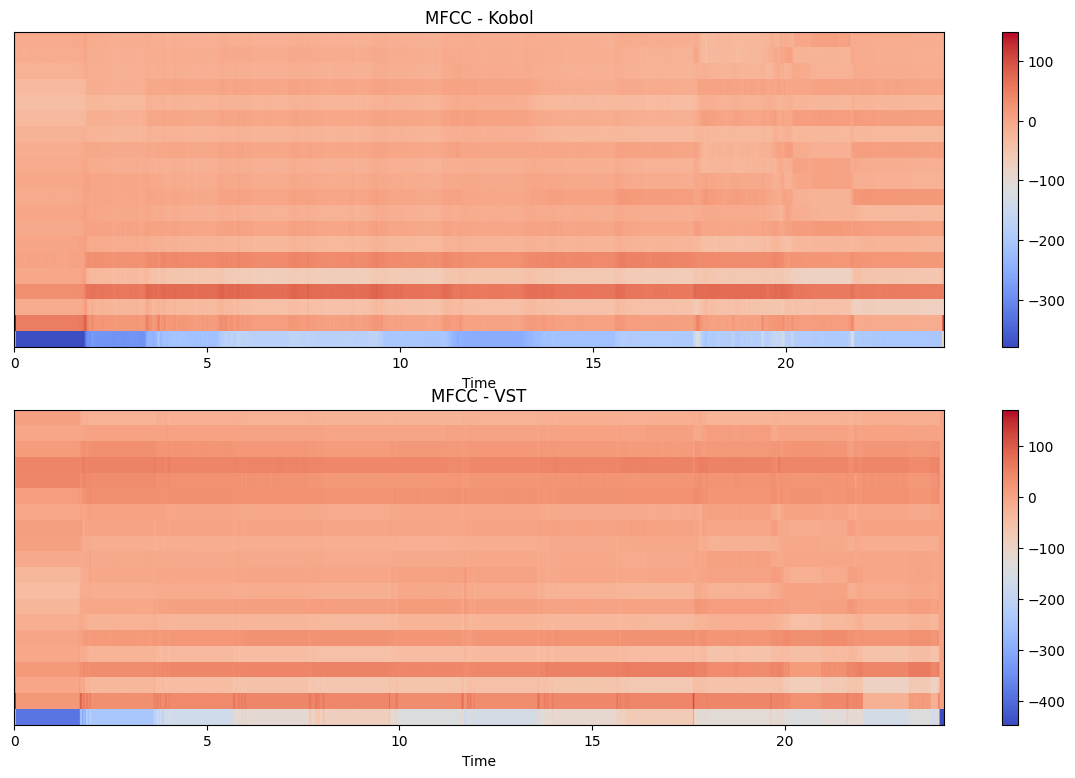

In [66]:
kobol='/content/drive/MyDrive/_Thesis/AUDIOS-sweep/sweep-kobol.wav'
vst = '/content/drive/MyDrive/_Thesis/AUDIOS-sweep/sweep-vst.wav'
plot_mfccs(kobol, vst)

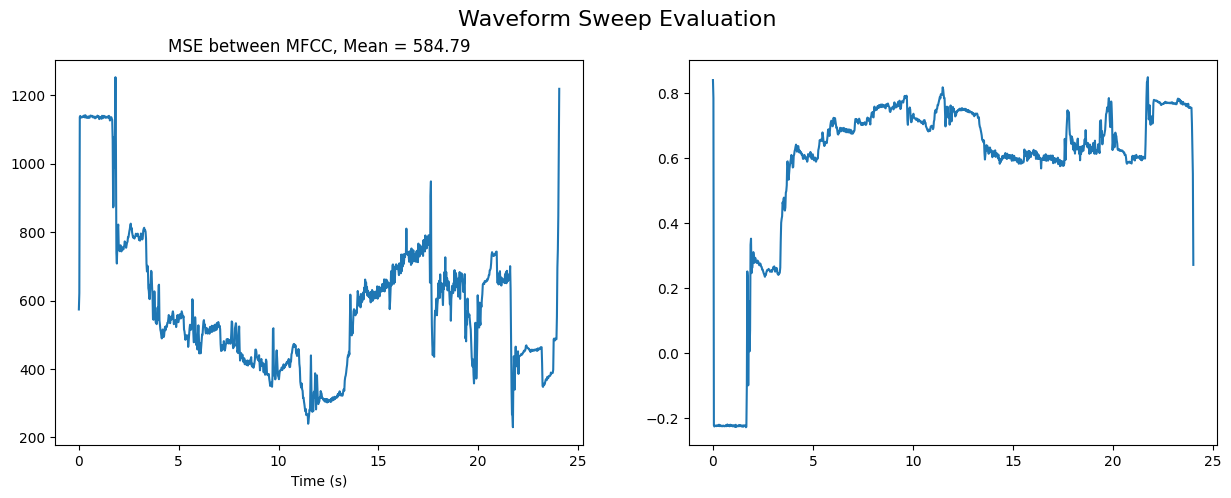

In [69]:
kobol='/content/drive/MyDrive/_Thesis/AUDIOS-sweep/sweep-kobol.wav'
vst = '/content/drive/MyDrive/_Thesis/AUDIOS-sweep/sweep-vst.wav'
evaluate_waveform_sweep(kobol, vst)

## Spectrogram

In [80]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_two_spectrograms(file_path1, file_path2):
    """
    Plot spectrograms of two audio signals side by side.

    :param file_path1: str, path to the first audio file.
    :param file_path2: str, path to the second audio file.
    """
    # Load the first audio file
    audio_data1, sampling_rate1 = librosa.load(file_path1, sr=None)
    S1 = librosa.stft(audio_data1)
    S_db1 = librosa.amplitude_to_db(np.abs(S1), ref=np.max)

    # Load the second audio file
    audio_data2, sampling_rate2 = librosa.load(file_path2, sr=None)
    S2 = librosa.stft(audio_data2)
    S_db2 = librosa.amplitude_to_db(np.abs(S2), ref=np.max)

    # Get only the file names from the paths
    file_name1 = os.path.basename(file_path1)
    file_name2 = os.path.basename(file_path2)

    # Create a figure with two subplots (one for each spectrogram)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the spectrogram for the first audio signal
    img1 = librosa.display.specshow(S_db1, sr=sampling_rate1, x_axis='time', y_axis='linear', ax=ax[0])
    ax[0].set(title=f'Spectrogram of {file_name1}')
    fig.colorbar(img1, ax=ax[0], format="%+2.f dB")

    # Plot the spectrogram for the second audio signal
    img2 = librosa.display.specshow(S_db2, sr=sampling_rate2, x_axis='time', y_axis='linear', ax=ax[1])
    ax[1].set(title=f'Spectrogram of {file_name2}')
    fig.colorbar(img2, ax=ax[1], format="%+2.f dB")

    # Show the plots
    plt.tight_layout()
    plt.show()


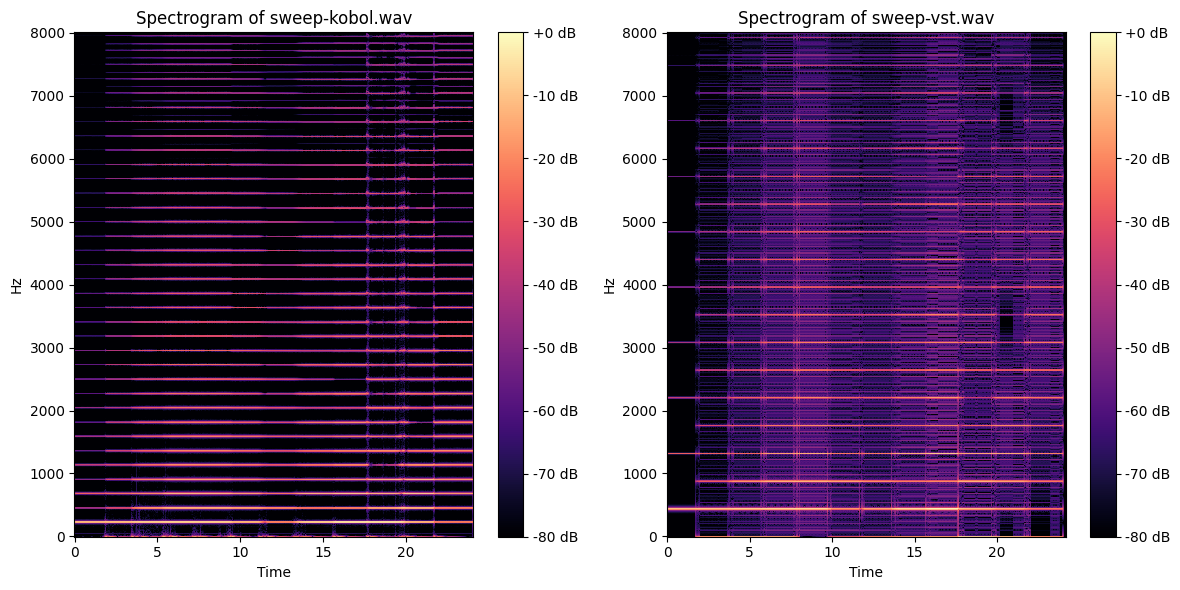

In [81]:
plot_two_spectrograms(kobol, vst)